# 2018-12-11 : LIP Spiking Network, biolike network
Cleaning the code, making the network spiking even when not stimulates, introducing population recurrence

In [1]:
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import numpy as np
import matplotlib.pyplot as plt
import random

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# Les fonctions

In [2]:
def make_random_sequence(amplitude, simtime, blocks, verbose=True):
    '''
    Creates a random injection sequence of N blocks in Priors A/B and Sample A/B 
    that the network has to discriminate.
    The structure is not (yet ?) ambiguous, meaning that injection is 
    always into ONE prior and ONE sample, not TWO priors and one sample 

    Each sequence lasts for simtime/number of blocks, i.e. for 5 blocks and 1s of 
    simulation, each block lasts 200 ms (hence the need for a long simtime)

    In each sequence, the injection of the prior always starts 150 ms before 
    the injection of the sample (hence, again, the need for a long simtime)

    Currents are injected inside the function, but returns a list structure as
    [blcok stop time, prior chosen, sample chosen]

    --> do_permanent : inject a smaller(/20) baseline current for the whole simulation 
    duration, which produces noise in the system
    '''

    sequence_list = []
    for block in range(blocks):
        block += 1  # otherwise we have negative start times
        if verbose:
            print('-----Block %s-------' % block)
            print('Prior times')
            print('Starting time', (block-1) * (simtime/blocks))
            print('Stopping time', block*(simtime/blocks))
            print('Sampling times')
            print('Starting time', ((block-1) * (simtime/blocks))+150)
            print('Stopping time', block*(simtime/blocks))

        pulse_prior = sim.DCSource(amplitude=amplitude,
                                   start=(block-1) * (simtime/blocks),
                                   stop=block*(simtime/blocks))
        pulse_sample = sim.DCSource(amplitude=amplitude,
                                    start=((block-1) * (simtime/blocks)) + 150,
                                    stop=block*(simtime/blocks))

        prior_injected = random.choice([Prior_A, Prior_B])
        sample_injected = random.choice([Sample_A, Sample_B])

        pulse_prior.inject_into(prior_injected)
        pulse_sample.inject_into(sample_injected)

        sequence_list.append(
            [block*(simtime/blocks), prior_injected.label, sample_injected.label])

    pulse_inhibition = sim.DCSource(
        amplitude=amplitude*1.2, start=.1, stop=simtime)
    pulse_inhibition.inject_into(I)

    return sequence_list

In [3]:
def cut_spiketrain(array, window, window_size):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype=float)

        spiketrain_cut = np.where(
            (spiketrain_array > window*window_size) & (spiketrain_array < (window+1)*window_size))[0]

        spiketrain_len.append(len(spiketrain_cut))

    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [4]:
def MegaRasterPlot(M_NM, Prior_A, Prior_B,
                   Sample_A, Sample_B,
                   I, Inter_A, Inter_B,
                   simtime,
                   title='Title', markersize=.5,
                   figsize=(9, 6), shifts=None):

    # oh la jolie double fonction
    def plot_spiketrains(ax, spikes, color, do_ticks):
        for spiketrain in spikes.spiketrains:
            y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
            ax.scatter(spiketrain, y, color=color, s=markersize)
            if not do_ticks:
                ax.set_xticklabels([])
            if shifts != None:
                for i, times in enumerate(shifts):
                    ax.axvline(x=times, color='k',
                               linestyle='-.', linewidth=1)

    fig, axs = plt.subplots(nrows=8, ncols=1, figsize=figsize)

    # MNM
    plot_spiketrains(axs[0], M_NM, color='k', do_ticks=True)
    axs[0].set_title('OUTPUT : Match/NonMatch Population')
    axs[0].set_xlim(-10, simtime+10)

    # Priors
    plot_spiketrains(axs[1], Prior_A, color='b', do_ticks=False)
    axs[1].set_title('Prior : A Population')
    axs[1].set_xlim(-10, simtime+10)
    plot_spiketrains(axs[2], Prior_B, color='b', do_ticks=False)
    axs[2].set_title('Prior : B Population')
    axs[2].set_xlim(-10, simtime+10)

    # Samples
    plot_spiketrains(axs[3], Sample_A, color='r', do_ticks=False)
    axs[3].set_title('Sample : A Population')
    axs[3].set_xlim(-10, simtime+10)
    plot_spiketrains(axs[4], Sample_B, color='r', do_ticks=False)
    axs[4].set_title('Sample : B Population')
    axs[4].set_xlim(-10, simtime+10)

    # Interneurons
    plot_spiketrains(axs[5], I, color='g', do_ticks=False)
    axs[5].set_title('Permanent inhibition population')
    axs[5].set_xlim(-10, simtime+10)
    plot_spiketrains(axs[6], Inter_A, color='g', do_ticks=False)
    axs[6].set_title('Inhibition : A population')
    axs[6].set_xlim(-10, simtime+10)
    plot_spiketrains(axs[7], Inter_B, color='g', do_ticks=True)
    axs[7].set_title('Inhibition : B population')
    axs[7].set_xlim(-10, simtime+10)

    plt.xlabel('Time(ms)')
    return fig, axs

# Hyperparamètres de simulation

In [5]:
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }
N_pop = 50
simtime = 2000
random_percent = 10
block_windows = 4

sparseness = .25

sparse_connector = sim.FixedProbabilityConnector(sparseness)

rng = sim.NumpyRNG(seed=42)
sigma = .01

inhibition_weight = rnd('normal_clipped', mu=.9/N_pop, sigma=sigma, low=0.01,
                   high=5,
                   rng=rng)
inter_I_weights = rnd('normal_clipped', mu=.15/N_pop, sigma=sigma, low=0.01,
                      high=5,
                      rng=rng)
prior_weights = rnd('normal_clipped', mu=.15/(N_pop*100), sigma=sigma, low=0.01,
                    high=5, rng=rng)
sample_weights = rnd('normal_clipped', mu=.5/N_pop, sigma=sigma, low=0.01,
                     high=5,
                     rng=rng)

delays=rnd('normal_clipped', mu = 1, sigma = .1, low = 0.1,
             high = 5,
             rng = rng)


I_syn=sim.StaticSynapse(weight = inhibition_weight, delay = delays)
inter_I_syn=sim.StaticSynapse(weight = inter_I_weights, delay = delays)
prior_static_syn=sim.StaticSynapse(weight = prior_weights, delay = delays)
sample_syn=sim.StaticSynapse(weight = sample_weights, delay = delays)

# Populations

In [6]:
sim.setup()

# on randomise un peu les tailles de populations
rand_pop = np.random.randint(-N_pop/random_percent, N_pop/random_percent)
M_NM = sim.Population(N_pop+rand_pop, sim.IF_cond_exp(**neuron_parameters),
                      initial_values={"v": neuron_parameters["v_reset"]},
                      label="Match/NonMatch")

rand_pop = np.random.randint(-N_pop/random_percent, N_pop/random_percent)
I = sim.Population(N_pop+rand_pop, sim.IF_cond_exp(**neuron_parameters),
                   initial_values={"v": neuron_parameters["v_reset"]},
                   label="Constant Inhibitor")

rand_pop = np.random.randint(-N_pop/random_percent, N_pop/random_percent)
Prior_A = sim.Population(N_pop+rand_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Prior A")
Prior_B = sim.Population(N_pop+rand_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Prior B")

rand_pop = np.random.randint(-N_pop/random_percent, N_pop/random_percent)
Sample_A = sim.Population(N_pop+rand_pop, sim.IF_cond_exp(**neuron_parameters),
                          initial_values={"v": neuron_parameters["v_reset"]},
                          label="Sample A")
Sample_B = sim.Population(N_pop+rand_pop, sim.IF_cond_exp(**neuron_parameters),
                          initial_values={"v": neuron_parameters["v_reset"]},
                          label="Sample B")

rand_pop = np.random.randint(-N_pop/random_percent, N_pop/random_percent)
Inter_A = sim.Population(N_pop+rand_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Inter A")
Inter_B = sim.Population(N_pop+rand_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Inter B")

populations = [M_NM, I, Inter_A, Inter_B, Prior_A, Prior_B, Sample_A, Sample_B]

# Synapses

In [7]:
# inhibitory connections
I_to_MNM = sim.Projection(I, M_NM,
                          connector=sparse_connector,
                          synapse_type=I_syn,
                          receptor_type='inhibitory',
                          label="I to MNM connection")

Ia_to_I = sim.Projection(Inter_A, I,
                         connector=sparse_connector,
                         synapse_type=inter_I_syn,
                         receptor_type='inhibitory',
                         label="Ia to I connection")
Ib_to_I = sim.Projection(Inter_B, I,
                         connector=sparse_connector,
                         synapse_type=inter_I_syn,
                         receptor_type='inhibitory',
                         label="Ib to I connection")

# priors
TA_to_Ia = sim.Projection(Prior_A, Inter_A,
                          connector=sparse_connector,
                          synapse_type=prior_static_syn,
                          receptor_type='excitatory',
                          label="TA to Ia connection")

TB_to_Ib = sim.Projection(Prior_B, Inter_B,
                          connector=sparse_connector,
                          synapse_type=prior_static_syn,
                          receptor_type='excitatory',
                          label="TB to Ib connection")

# samples (=input)
SA_to_MNM = sim.Projection(Sample_A, M_NM,
                           connector=sparse_connector,
                           synapse_type=sample_syn,
                           receptor_type='excitatory',
                           label="SA to MNM connection")
SA_to_Ia = sim.Projection(Sample_A, Inter_A,
                          connector=sparse_connector,
                          synapse_type=prior_static_syn,
                          receptor_type='excitatory',
                          label="SA to Ia connection")

SB_to_MNM = sim.Projection(Sample_B, M_NM,
                           connector=sparse_connector,
                           synapse_type=sample_syn,
                           receptor_type='excitatory',
                           label="SA to Ia connection")
SB_to_Ib = sim.Projection(Sample_B, Inter_B,
                          connector=sparse_connector,
                          synapse_type=prior_static_syn,
                          receptor_type='excitatory',
                          label="SA to Ia connection")

# Recurrent synapses

In [8]:
# a trick to get only the excitatories pop
exc_pop = []
for pop in populations:
    if not 'in' in pop.label.lower():
        exc_pop.append(pop)

# Recurrent connexions
sparse_connector_recurrent = sim.FixedProbabilityConnector(.05)
recurrent_weights = rnd('normal_clipped', mu=.05/N_pop, sigma=.001, low=0.0001,
                     high=.02,
                     rng=rng)
rec_syn=sim.StaticSynapse(weight = recurrent_weights, delay = delays)
for exc in exc_pop:
    other_excs = exc_pop.copy()
    other_excs.remove(exc)
    for other_exc in other_excs :
        rec_proj = sim.Projection(exc, other_exc,
                       connector=sparse_connector_recurrent,
                       synapse_type=rec_syn,
                       receptor_type='excitatory')
        #plt.hist(rec_proj.getWeights());plt.pause(.1)

# Adding poisson noise

In [9]:
noisy_pop = sim.Population(N_pop,
                           sim.SpikeSourcePoisson(
                               rate=10, duration=simtime, start=0),
                           label="Entree Orientation")

noisy_connector = sim.OneToOneConnector()
noisy_weights = rnd('normal_clipped', mu=.2/N_pop, sigma=.001, low=0.0001,
                     high=.02,
                     rng=rng)
noisy_delays=rnd('normal_clipped', mu = 2, sigma = 2, low = 0.1,
             high = 10,
             rng = rng)
noisy_syn=sim.StaticSynapse(weight = 1, delay = noisy_delays)

for pop in populations :
    sim.Projection(noisy_pop, pop,
                             connector = noisy_connector,
                             synapse_type = noisy_syn,
                             receptor_type = 'excitatory')

# Making blocks and running simulation

In [10]:
sequence = make_random_sequence(.4, simtime, block_windows, verbose=False)

In [11]:
for pop in populations :
    pop.record('spikes')
noisy_pop.record('spikes')
sim.run(simtime)
sim.end()

In [12]:
M_NM_data = M_NM.get_data().segments[0]

Prior_A_data = Prior_A.get_data().segments[0]
Prior_B_data = Prior_B.get_data().segments[0]

Sample_A_data = Sample_A.get_data().segments[0]
Sample_B_data = Sample_B.get_data().segments[0]

I_data = I.get_data().segments[0]
Inter_A_data = Inter_A.get_data().segments[0]
Inter_B_data = Inter_B.get_data().segments[0]

/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/recording/__init__.py:264: UserWarning: Recorded at least one spike after t_stop
  warn("Recorded at least one spike after t_stop")


# Plotting

Full sequence :
[500.0, 'Prior A', 'Sample B']
[1000.0, 'Prior B', 'Sample B']
[1500.0, 'Prior A', 'Sample A']
[2000.0, 'Prior B', 'Sample B']
Block # 0 , total spikes : 467
Block # 1 , total spikes : 678
Block # 2 , total spikes : 643
Block # 3 , total spikes : 646


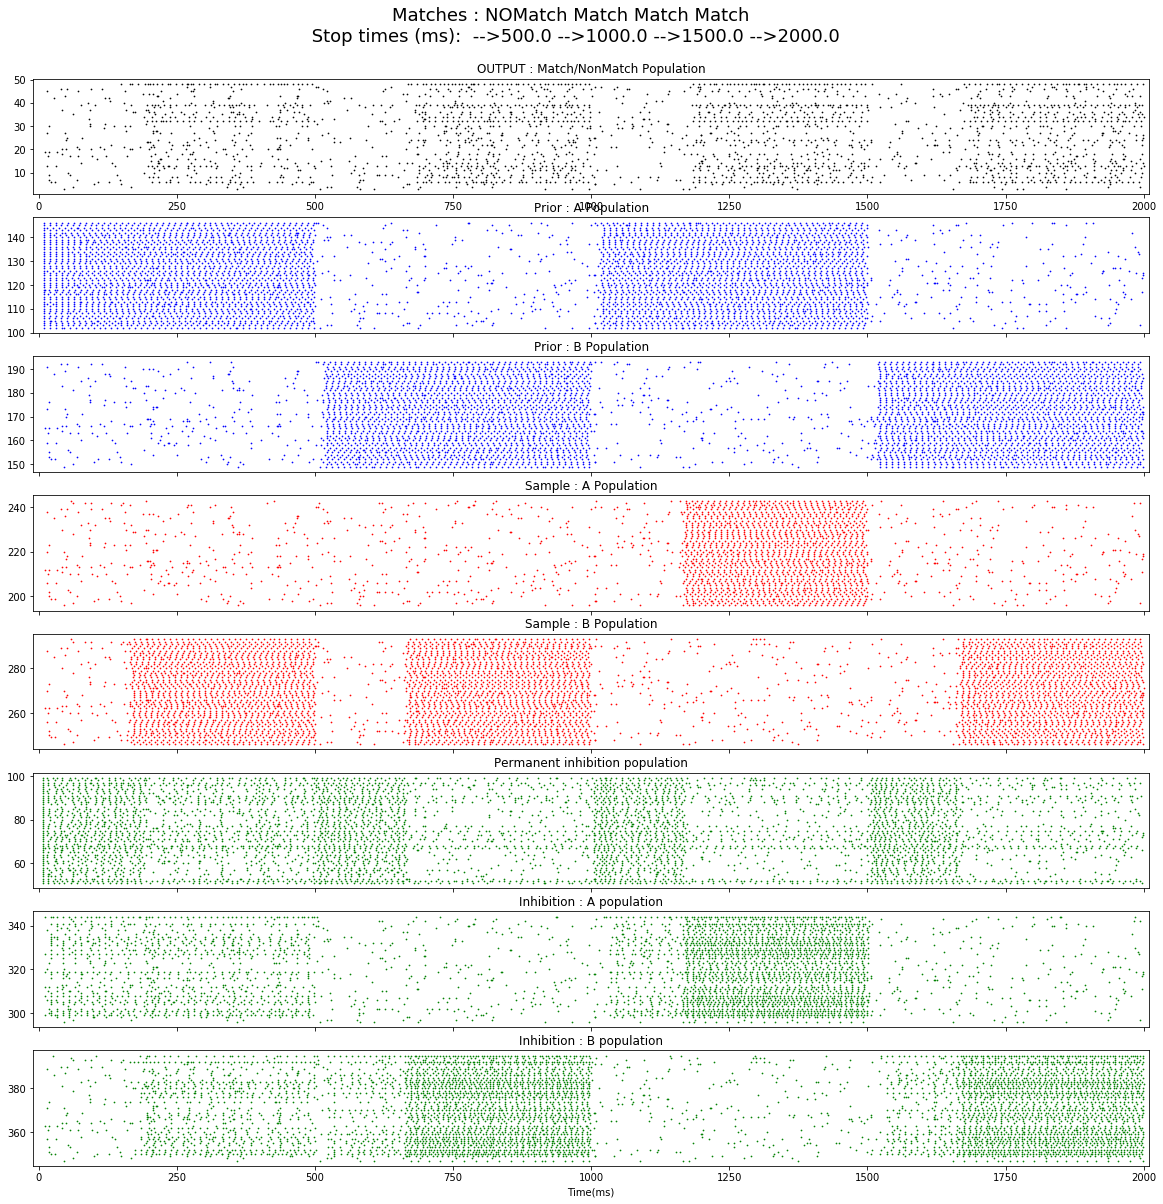

In [13]:
# Plotting
MegaRasterPlot(M_NM_data, Prior_A_data, Prior_B_data,
               Sample_A_data, Sample_B_data,
               I_data, Inter_A_data, Inter_B_data,
               simtime=simtime,
               figsize=(20, 20))

# Titre
strseq = ''
for block in sequence:
    if block[1].split(' ')[1] == block[2].split(' ')[1]:
        strseq += 'Match '
    else:
        strseq += 'NOMatch '
strtime = ''
for block in sequence:
    strtime += (' -->')
    strtime += str(block[0])

# printing sequence
print('Full sequence :')
for s in sequence:
    print(s)

# printing FR
windows = block_windows
for window in range(windows):
    print('Block # %s , total spikes : ' %
          window+str((cut_spiketrain(M_NM_data, window, simtime/windows).sum())))

plt.suptitle(x=.5, y=.93,
             t='Matches : '+strseq+'\n Stop times (ms): '+strtime,
             fontsize=18)
plt.show()

# Debugging trash cells

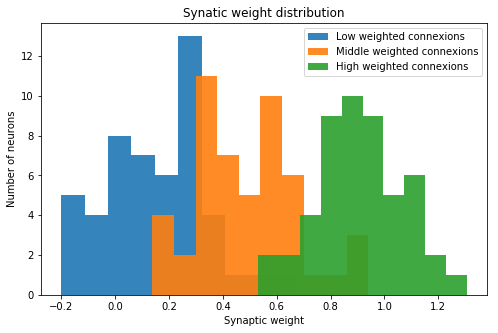

In [14]:
plt.figure(figsize=(8, 5))

mu, sigma = .15, .2  # mean and standard deviation
s = np.random.normal(mu, sigma, N_pop)
plt.hist(s, alpha=.9, label='Low weighted connexions')

mu, sigma = .5, .2  # mean and standard deviation
s = np.random.normal(mu, sigma, N_pop)
plt.hist(s, alpha=.9, label='Middle weighted connexions')

mu, sigma = .9, .2  # mean and standard deviation
s = np.random.normal(mu, sigma, N_pop)
plt.hist(s, alpha=.9, label='High weighted connexions')

plt.xlabel('Synaptic weight')
plt.ylabel('Number of neurons')
plt.title('Synatic weight distribution')
plt.legend()
plt.show()

(array([114., 138., 121.,  95.,  47.,  31.,  12.,   3.,   1.,   1.]),
 array([0.01003105, 0.01468067, 0.0193303 , 0.02397993, 0.02862955,
        0.03327918, 0.03792881, 0.04257843, 0.04722806, 0.05187769,
        0.05652731]),
 <a list of 10 Patch objects>)

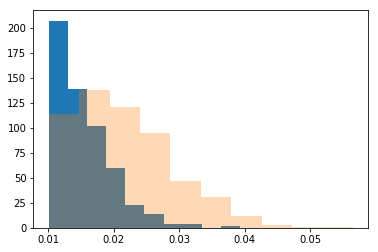

In [15]:
plt.hist(TA_to_Ia.getWeights())
plt.hist(I_to_MNM.getWeights(), alpha = .3)
plt.hist()

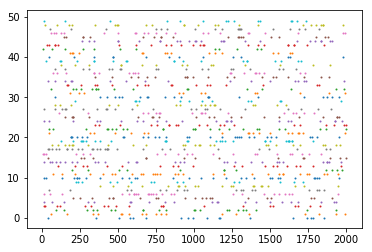

In [16]:
for it, spiketrain in enumerate(noisy_pop.get_data().segments[0].spiketrains):
    plt.scatter( spiketrain,
               np.full(len(spiketrain),it, ),
               s = 1)